In [203]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [204]:
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [205]:
X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)

In [206]:
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255

In [207]:
class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ
    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      訓練データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size = 20, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)
    def __len__(self):
        return self._stop
    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]        
    def __iter__(self):
        self._counter = 0
        return self
    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]

### 【問題1】〜 【問題7】

epoch: 1, loss: 0.2773892648259215
epoch: 2, loss: 0.21435526385560733
epoch: 3, loss: 0.1787011308242858
epoch: 4, loss: 0.15389091950958775
epoch: 5, loss: 0.13511698102680797
epoch: 6, loss: 0.1201893486783529
epoch: 7, loss: 0.10792678920403455
epoch: 8, loss: 0.09762148658873795
epoch: 9, loss: 0.08881373232312709
epoch: 10, loss: 0.08118437117785068
epoch: 11, loss: 0.07450102641557184
epoch: 12, loss: 0.06858968647883952
epoch: 13, loss: 0.06331752240808147
epoch: 14, loss: 0.05858157522259207
epoch: 15, loss: 0.054301051081436166
epoch: 16, loss: 0.050411883564159134
epoch: 17, loss: 0.046862803663306855
epoch: 18, loss: 0.043612497104870813
epoch: 19, loss: 0.04062752304662505
epoch: 20, loss: 0.0378807324156431


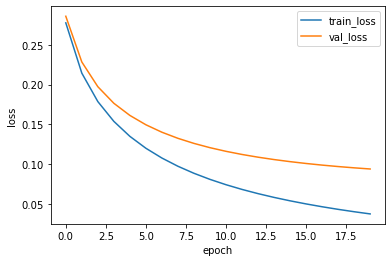

accuracy: 0.97125


In [208]:
class ScratchSimpleNeuralNetrowkClassifier():

    def __init__(self, epoch, batch_size, n_nodes1, n_nodes2, n_output, verbose = True):
        self.verbose = verbose
        self.epoch = epoch
        self.sigma = 0.1 #重みの初期値のハイパーパラメータ
        self.batch_size = batch_size
        self.n_nodes1 = n_nodes1
        self.n_nodes2 = n_nodes2
        self.n_output = n_output
        self.n_features = 784

        self.loss_e = np.array([])  #訓練データのlossを保存する。
        self.loss_v = np.array([])  #検証データのlossを保存する。
        
        #重み、バイアスの初期値を設定
        self.W1 = self.sigma * np.random.randn(self.n_features, self.n_nodes1)
        self.B1 =  np.zeros((self.n_nodes1,))
        self.A1= None
        self.Z1 = None

        self.W2 = self.sigma * np.random.randn(self.n_nodes1, self.n_nodes2)
        self.B2 = np.zeros((self.n_nodes2, ))
        self.A2 = None
        self.Z2 = None
        
        self.W3 = self.sigma * np.random.randn(self.n_nodes2, self.n_output)
        self.B3 = np.zeros((self.n_output,))
        self.A3 = None
        self.Z3 = None

    #フォワードプロパゲーション
    def _forward_prop(self, mini_X_train):

        self.A1 = mini_X_train @ self.W1 + self.B1
        self.Z1 = self._activating_function(self.A1, func_type=1)

        self.A2 = self.Z1 @ self.W2 + self.B2
        self.Z2 = self._activating_function(self.A2, func_type=1)
            
        self.A3 = self.Z2 @ self.W3 + self.B3
        self.Z3 = self._softmax_function(self.A3)
            
        return
    
    #バックプロパゲーション
    def _back_prop(self, mini_X, mini_Y):
        
        alpha = 0.01
                
        #３層目の逆伝播
        dL_dA3 = 1 / self.batch_size * (self.Z3 - mini_Y)
        dL_dB3 = np.sum(dL_dA3, axis=0)
        dL_dW3 = (self.Z2.T) @ dL_dA3
        dL_dZ2 = dL_dA3 @ (self.W3.T)
        
        self.B3 -= alpha * dL_dB3
        self.W3 -= alpha * dL_dW3

        #2層目の逆伝播
        dL_dA2 = dL_dZ2 * (1 - self.Z2 ** 2)
        dL_dB2 = np.sum(dL_dA2, axis=0)
        dL_dW2 = (self.Z1.T) @ dL_dA2
        dL_dZ1 = dL_dA2 @ (self.W2.T)

        self.B2 -= alpha * dL_dB2
        self.W2 -= alpha * dL_dW2
            
        #1層目の逆伝播
        dL_dA1 = dL_dZ1 * (1 - self.Z1 ** 2) 
        dL_dB1 = np.sum(dL_dA1, axis=0)
        dL_dW1 = (mini_X.T) @ dL_dA1

        self.B1 -= alpha * dL_dB1
        self.W1 -= alpha * dL_dW1
      
        return

    def fit(self, X_train, y_train, X_val=None, y_val=None):

        for epoch in range(self.epoch):
            get_mini_batch = GetMiniBatch(X_train, y_train, batch_size=20)
            for mini_X_train, mini_y_train in get_mini_batch:

                #y_trainを　one-hot表現に変換する。
                mini_Y = self._one_hot_encoding(mini_y_train)

                #フォワードプロバゲーション
                self._forward_prop(mini_X_train)
                                
                #バックプロパゲーション
                self._back_prop(mini_X_train, mini_Y)

            #損失関数の計算
            self._calc_loss(X_train, y_train, X_val, y_val)

            #エポック毎の損失関数を表示
            print(f'epoch: {epoch+1}, loss: {self.loss_e[-1]}')
        
        if self.verbose:
            #学習による損失関数の減少をプロット
            x_idx = range(len(self.loss_e))
            plt.plot(x_idx, self.loss_e, label='train_loss')
            plt.plot(x_idx, self.loss_v, label='val_loss')
            plt.xlabel('epoch')
            plt.ylabel('loss')
            plt.legend()
            plt.show()

    #活性化関数
    def _activating_function(self, A, func_type=1):
        
        #シグモイド関数
        if func_type == 0:
            Z = 1 / (1 + np.exp(-1 * A))
            
        #ハイパボリックタンジェント関数
        if func_type == 1:
            Z = np.tanh(A)
            
        return Z

    #ソフトマックス関数（辞書型→ndarrayとしたが、辞書型を経由せず書けなかった）
    def _softmax_function(self, A):

        Z_dic={}
        for k in range(self.n_output):
            Z_dic[k] = np.exp(A[:, k]).reshape(-1,1) / np.sum(np.exp(A), axis=1).reshape(-1,1)
         
            if k == 0:
                Z = Z_dic[k]
            else:
                Z = np.hstack((Z, Z_dic[k]))
            
        return Z

    #クロスエントロピー誤差の計算
    def _cross_entropy_error(self, Y, size):
        L = -1 / size * np.sum(Y *np.log(self.Z3))
            
        return L
    
    #訓練データ、検証データのlossを計算して保存する。
    def _calc_loss(self, X_train, y_train, X_val, y_val):
        #訓練データ
        self._forward_prop(X_train)
        Y_train = self._one_hot_encoding(y_train)
        self.loss_e = np.append(self.loss_e, self._cross_entropy_error(Y_train, 60000*0.8))

        #検証データ
        self._forward_prop(X_val)
        Y_val = self._one_hot_encoding(y_val)
        self.loss_v = np.append(self.loss_v, self._cross_entropy_error(Y_val, 60000*0.2))
            
        return

    #ラベルデータをone-hot形式に変換
    def _one_hot_encoding(self, mini_y_train):
        mini_Y = np.zeros((len(mini_y_train), 10))
        for i, label in enumerate(mini_y_train):
            mini_Y[i, label] = 1
            
        return mini_Y
    
    #推定
    def predict(self, X_test):
        self._forward_prop(X_test)
        y_pred = np.argmax(self.Z3, axis=1)
        
        return y_pred

#訓練データ、テストデータの分割
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2)
    
#機械学習インスタンスの作成
nn = ScratchSimpleNeuralNetrowkClassifier(verbose = True, epoch = 20,
            batch_size = 20, n_nodes1 = 400, n_nodes2 = 200, n_output = 10)

#機械学習
nn.fit(X_train, y_train, X_test, y_test)

#機械学習による推定
y_pred = nn.predict(X_test)

#精度の確認
acc = accuracy_score(y_test, y_pred)
print('accuracy:', acc)
